In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import os
from glob import glob
import cv2
import imageio
import matplotlib.pyplot as plt
from PIL import Image

In [47]:
DIR_LIST =['augmented_data/train_org/',
           'augmented_data/train_sr/HR',
           'augmented_data/train_sr/LRBICUBIC',
           'augmented_data/train_sr/LRX2',
           'save_model']
               
for dir in DIR_LIST:
    os.makedirs(dir, exist_ok=True)  
    
DATA_DIR = ['data/bsd200', 'data/yang91']
OUTPUT_DIR = 'augmented_data/train_org/'

BICUBIC_DIR = 'augmented_data/train_sr/LRBICUBIC'
LRX2_DIR = 'augmented_data/train_sr/LRX2'
HR_DIR = 'augmented_data/train_sr/HR'

TEST_DIR = 'data/set5'
TEST_OUTPUT_DIR = 'test/'
MODEL_PATH = 'save_model/DCSCN_V2_e100_lr0.0001.pt'

SCALE_FACTOR = 2

In [3]:
def generateAugmentedImg(file_list):
    
    img_org = cv2.imread(file_list[0])
    # original image
    
    img_0 = img_org
    path_0 = file_list[2] + "img_" + str(file_list[1]) + "_0" + ".png"
    cv2.imwrite(path_0, img_0)
    # original image
    
    img_1 = np.flipud(img_org)
    path_1 = file_list[2] + "img_" + str(file_list[1]) + "_1"  + ".png"
    cv2.imwrite(path_1, img_1)
    # flip vertical
    
    img_2 = np.fliplr(img_org)
    path_2 = file_list[2] + "img_" + str(file_list[1]) + "_2"  + ".png"
    cv2.imwrite(path_2, img_2)
    # flip horizontal
    
    img_3 = np.fliplr(np.flipud(img_org))
    path_3 = file_list[2] + "img_" + str(file_list[1]) + "_3"  + ".png"
    cv2.imwrite(path_3, img_3)
    # flip vertical - horizontal
    
    img_4 = np.rot90(img_org)
    path_4 = file_list[2] + "img_" + str(file_list[1]) + "_4"  + ".png"
    cv2.imwrite(path_4, img_4)
    # rotation 90 degree(CCW)
    
    img_5 = np.rot90(img_org, -1)
    path_5 = file_list[2] + "img_" + str(file_list[1]) + "_5"  + ".png"
    cv2.imwrite(path_5, img_5)
    # rotation 270 degree(CCW)
    
    img_6 = np.flipud(np.rot90(img_org))
    path_6 = file_list[2] + "img_" + str(file_list[1]) + "_6"  + ".png"
    cv2.imwrite(path_6, img_6)
    # rotation 90 degree(CCW) - flip vertical

    img_7 = np.flipud(np.rot90(img_org, -1))
    path_7 = file_list[2] + "img_" + str(file_list[1]) + "_7"  + ".png"
    cv2.imwrite(path_7, img_7)
    # rotation 270 degree(CCW) - flip vertical

# 데이터 - 증강

In [4]:
file_list = []
file_num = 0

for i in DATA_DIR:
    for j, file in enumerate(sorted(glob(i + '/*'))):
        file_list.append([file, file_num, OUTPUT_DIR])
        file_num += 1
        
print(len(file_list), "original image loaded")
# load original image


for i in range(len(file_list)):
    generateAugmentedImg(file_list[i])
    # generate Augmented images
    
print("augmented image genarated")

291 original image loaded
augmented image genarated


# 데이터 - HR, LR, BI 생성

In [5]:
def cvtBGR2Y(image):

    R = image[:,:,2]
    G = image[:,:,1]
    B = image[:,:,0]
    
    # Y' = 16  +  65.481  * R' + 128.553  * G' +  24.966  * B'
    Y = (16*255.0/256.0)  + (65.481/256.0*R +  128.553/256.0*G +  24.966/256.0*B)
    # convert cv2 BGR image to Y(CbCr) image
        
    return Y

In [6]:
def resizeImage(image, scale):
    
    width, height = image.shape[1], image.shape[0]
    new_width = int(width * scale)
    new_height = int(height * scale)
    
    image = Image.fromarray(image.reshape(height, width))
    image = image.resize([new_width, new_height], Image.BICUBIC)
    image = np.asarray(image)
    image = image.reshape(new_height, new_width)
    return image

In [7]:
def splitPatches(image, window_size, stride):
 
    size = image.itemsize
    # image item size
    
    shape = (1 + (image.shape[0] - window_size) // stride,
            1 + (image.shape[1] - window_size) // stride,
             window_size,
             window_size)
    strides = size * np.array([image.shape[1] * stride, stride, image.shape[1], 1])
             
    return np.lib.stride_tricks.as_strided(image, shape, strides)

In [32]:
def getImgPatches(image, window_size, stride):

    patches = splitPatches(image, window_size, stride)
    # split images into patches(sliding window)
    
    patches = patches.reshape(patches.shape[0] * patches.shape[1], 1, patches.shape[2], patches.shape[3])
    # reshape patches
    
    height, width = image.shape[0], image.shape[1]
    
    extra_patches = []
    if (image.shape[0] - window_size) % stride != 0:
        for x in range(0, image.shape[1] - window_size, stride):
            extra_patches.append(image[image.shape[0] - window_size - 1:image.shape[0] - 1, x:x + window_size:])

    if (width - window_size) % stride != 0:
        for y in range(0, image.shape[0] - window_size, stride):
            extra_patches.append(image[y: y + window_size, image.shape[1] - window_size - 1:image.shape[1] - 1])

    if len(extra_patches) > 0:
        org_size = patches.shape[0]
        patches = np.resize(patches, [org_size + len(extra_patches), patches.shape[1], patches.shape[2], patches.shape[3]])
        for i in range(len(extra_patches)):
            extra_patches[i] = extra_patches[i].reshape([1,extra_patches[i].shape[0], extra_patches[i].shape[1]])
            patches[org_size + i] = extra_patches[i]
    
    return patches

In [33]:
def getPatchList(train_list, HR_DIR, LRX2_DIR, BICUBIC_DIR):
    
    patch_size = 32
    patch_stride = 16
    # lr patch size
    
    patch_hr_size = patch_size * SCALE_FACTOR
    patch_hr_stride = patch_stride * SCALE_FACTOR
    # hr, bi patch size

    hr_list = []
    lr_list = []
    bi_list = []

    for image_path in train_list:
        image = cv2.imread(image_path)
        # load image(BGR)
        
        width, height = (image.shape[1]//SCALE_FACTOR) * SCALE_FACTOR, (image.shape[0]//SCALE_FACTOR)*SCALE_FACTOR
        hr_img = image[:height, :width, 0:3]
        # Adjust the image size to a multiple of SCALE_FACTOR.
        
        hr_y = cvtBGR2Y(hr_img)
        lr_y = resizeImage(hr_y, 1/SCALE_FACTOR)
        bi_y = resizeImage(lr_y, SCALE_FACTOR)
        
        #lr_y = cv2.resize(hr_y, dsize=(0, 0), fx=(1/SCALE_FACTOR), fy=(1/SCALE_FACTOR), interpolation=cv2.INTER_CUBIC)
        #bi_y = cv2.resize(lr_y, dsize=(0, 0), fx=SCALE_FACTOR, fy=SCALE_FACTOR, interpolation=cv2.INTER_CUBIC)
        # convert image to Y image, resize into lr & bi
        # cv2 resize function result is not same with PIL resize!!!
                
        hr_y_patches = getImgPatches(hr_y, patch_hr_size, patch_hr_stride)
        lr_y_patches = getImgPatches(lr_y, patch_size, patch_stride)
        bi_y_patches = getImgPatches(bi_y, patch_hr_size, patch_hr_stride)
        # split hr, lr, bi into patches
              
        hr_list.append(hr_y_patches)
        lr_list.append(lr_y_patches)
        bi_list.append(bi_y_patches)
        # append hr. lr, bi Y patches into list
        
    hr_array = np.concatenate(hr_list)
    lr_array = np.concatenate(lr_list)
    bi_array = np.concatenate(bi_list)
    # concatenate list into array  (2328*[num_patches,1,patch_size,patch_size]) --> (2328*num_patches,1,patch_size,patch_size)

    return hr_array, lr_array, bi_array 

In [34]:
train_list = []

for i in (sorted(glob(OUTPUT_DIR + '/*'))):
        train_list.append(i)

HR_ARRAY, LR_ARRAY, BI_ARRAY = getPatchList(train_list, HR_DIR, LRX2_DIR, BICUBIC_DIR)
# split train images --> hr, lr, bi patches

# 데이터셋 생성

In [35]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, hr_array, lr_array, bi_array, transform=None):
        self.hr_array = hr_array
        self.lr_array = lr_array
        self.bi_array = bi_array
        
    def __len__(self):
        return len(self.hr_array)
        
    def __getitem__(self, index):
        hr = self.hr_array[index]
        lr = self.lr_array[index]
        bi = self.bi_array[index]
        
        return hr, lr, bi

In [36]:
train_dataset = CustomDataset(HR_ARRAY, LR_ARRAY, BI_ARRAY)

# 모델 생성

![nn](./figure1_v2.png)

In [37]:
class DCSCN(nn.Module):
    
    def __init__(self, kernel_size = 3, n_channels = 64):
        super(DCSCN, self).__init__()
                
        # common layer
        self.drop = nn.Dropout(p=0.8)
        self.prelu = nn.PReLU() # nn.PReLU(self.conv1(x)) 방식 이용 불가. 별도 선언.
        
        # feature extraction layer
        self.conv1 = nn.Conv2d(1, 196, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv2 = nn.Conv2d(196, 166, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv3 = nn.Conv2d(166, 148, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv4 = nn.Conv2d(148, 133, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv5 = nn.Conv2d(133, 120, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv6 = nn.Conv2d(120, 108, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv7 = nn.Conv2d(108, 97, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv8 = nn.Conv2d(97, 86, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv9 = nn.Conv2d(86, 76, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv10 = nn.Conv2d(76, 66, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv11 = nn.Conv2d(66, 57, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv12 = nn.Conv2d(57, 48, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        
        ## he initialization
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)
        nn.init.kaiming_normal_(self.conv6.weight)
        nn.init.kaiming_normal_(self.conv7.weight)
        nn.init.kaiming_normal_(self.conv8.weight)
        nn.init.kaiming_normal_(self.conv9.weight)
        nn.init.kaiming_normal_(self.conv10.weight)
        nn.init.kaiming_normal_(self.conv11.weight)
        nn.init.kaiming_normal_(self.conv12.weight)
        
        # reconstruction layer
        self.A1 = nn.Conv2d(1301, 64, 1, stride = 1, bias = True)
        self.B1 = nn.Conv2d(1301, 32, 1, stride = 1, bias = True)
        self.B2 = nn.Conv2d(32, 32, kernel_size, stride = 1, padding=1,padding_mode="replicate",bias=True)
        
        ## he initialization
        nn.init.kaiming_normal_(self.A1.weight)
        nn.init.kaiming_normal_(self.B1.weight)
        nn.init.kaiming_normal_(self.B2.weight)
        
        # feature extraction layer
        self.UPsample = nn.Conv2d(96, 2*2*96, kernel_size, stride = 1, padding =1, padding_mode = "replicate", bias = True)
        self.pixelshuffle = nn.PixelShuffle(2)
        
        self.R = nn.Conv2d(96, 1, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        
        ## he initialization
        nn.init.kaiming_normal_(self.UPsample.weight)
        nn.init.kaiming_normal_(self.R.weight)
        
    def forward(self, x):
                
        # feature extraction network
        skip1 = self.drop(self.prelu(self.conv1(x)))
        skip2 = self.drop(self.prelu(self.conv2(skip1)))
        skip3 = self.drop(self.prelu(self.conv3(skip2)))
        skip4 = self.drop(self.prelu(self.conv4(skip3)))
        skip5 = self.drop(self.prelu(self.conv5(skip4)))
        skip6 = self.drop(self.prelu(self.conv6(skip5)))
        skip7 = self.drop(self.prelu(self.conv7(skip6)))
        skip8 = self.drop(self.prelu(self.conv8(skip7)))
        skip9 = self.drop(self.prelu(self.conv9(skip8)))
        skip10 = self.drop(self.prelu(self.conv10(skip9)))
        skip11 = self.drop(self.prelu(self.conv11(skip10)))
        skip12 = self.drop(self.prelu(self.conv12(skip11)))
        
        # reconstruction network
        recon_input = torch.cat([skip1, skip2, skip3, skip4, skip5, skip6, skip7, skip8, skip9, skip10, skip11, skip12], dim = 1)
        
        A1_out = self.drop(self.prelu(self.A1(recon_input)))
        
        B1_out = self.drop(self.prelu(self.B1(recon_input)))
        B2_out = self.drop(self.prelu(self.B2(B1_out)))
        
        recon_output = torch.cat([A1_out, B2_out], dim = 1)
        
        # up-sampling network
        UPsample_out = self.drop(self.pixelshuffle(self.UPsample(recon_output)))
        R_out = self.R(UPsample_out)
        
        return R_out

# 하이퍼 파라미터

In [38]:
learning_rate = 1e-4
num_epochs = 100
BATCH_SIZE  = 20
model_path = 'save_model'

In [39]:
data_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=True
    )

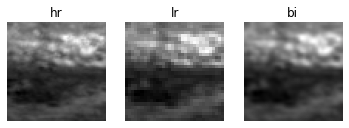

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure()
rows = 1
cols = 3

for hr, lr, bi in data_loader:
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(hr[0][0], cmap='gray')
    ax1.set_title('hr')
    ax1.axis("off")

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(lr[0][0], cmap='gray')
    ax2.set_title('lr')
    ax2.axis("off")

    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(bi[0][0], cmap='gray')
    ax3.set_title('bi')
    ax3.axis("off")

    plt.show()
    break

In [41]:
for hr, lr, bi in data_loader:
    print(hr[0][0])
    print(lr[0][0])
    print(bi[0][0])
    break

tensor([[110.6815, 114.6150, 115.0290,  ..., 129.8038, 129.7944, 126.9722],
        [108.2126, 108.9706, 110.0912,  ..., 126.3819, 124.6616, 122.6435],
        [116.7066, 115.2514, 115.8699,  ..., 121.4442, 122.2996, 122.8480],
        ...,
        [ 91.4292,  93.9956,  98.2729,  ...,  89.5232,  91.2341,  91.1366],
        [ 92.2847,  93.1401,  94.8511,  ...,  92.2847,  92.0383,  90.1323],
        [ 91.8432,  92.0896,  91.2341,  ...,  89.7183,  88.4214,  85.4041]],
       dtype=torch.float64)
tensor([[110.5253, 114.6804, 128.4118,  ..., 125.6086, 128.2604, 125.7275],
        [117.1332, 122.1659, 130.3287,  ..., 120.1252, 121.7958, 124.8525],
        [128.2619, 133.6702, 135.3667,  ..., 129.3484, 131.1638, 131.9124],
        ...,
        [100.0874, 101.9324,  98.3375,  ...,  96.9559,  93.7613,  89.7977],
        [ 95.3821, 100.9414, 101.8816,  ...,  89.4873,  90.8629,  91.5022],
        [ 92.4468,  94.3848,  97.9984,  ...,  89.5111,  90.4210,  88.7128]])
tensor([[109.5824, 110.4046, 112

# 모델 로드 & 학습

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = DCSCN().to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_func = nn.MSELoss().to(device)

for epochs in range(num_epochs):  
    
    for HR, LR, BI in data_loader:
                   
        recon = model(LR.to(device).float())
        recon += BI.to(device).float()
        loss = loss_func(recon, HR.to(device).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch: {}, Loss: {}, LR: {}'.format(epochs+1, loss.item(), learning_rate))
    
    if epochs % 10 == 0:
        save_model_path = model_path + "/DCSCN_V2_e{}_lr{}_loss{:4}.pt".format(epochs, learning_rate, loss.item())
        torch.save(model, save_model_path)
        print("Epoch {} model saved.".format(epochs+1))
        # save model per 10 epochs

save_model_path = model_path + "/DCSCN_V2_e{}_lr{}.pt".format(epochs+1, learning_rate)
torch.save(model, save_model_path)
print("EPOCH {} last model saved.".format(epochs+1))
# save last model

DCSCN(
  (drop): Dropout(p=0.8, inplace=False)
  (prelu): PReLU(num_parameters=1)
  (conv1): Conv2d(1, 196, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv2): Conv2d(196, 166, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv3): Conv2d(166, 148, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv4): Conv2d(148, 133, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv5): Conv2d(133, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv6): Conv2d(120, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv7): Conv2d(108, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv8): Conv2d(97, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv9): Conv2d(86, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate

# 테스트

평가 코드는 공정성을 위해 레퍼런스 코드 그대로 이용

evaluation notebook 참조